# Style Transfer using "Perceptual Losses for Real-Time Style Transfer and Super-Resolution" by Justin et.al  
http://arxiv.org/abs/1603.08155

In [6]:
%matplotlib inline
import importlib
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

import sys
sys.path.append('../PreTrainedModels')
from vgg16_avg import VGG16_Avg

import sys
sys.path.append('../utilities')
import utils2; importlib.reload(utils2)
from utils2 import *

limit_mem()

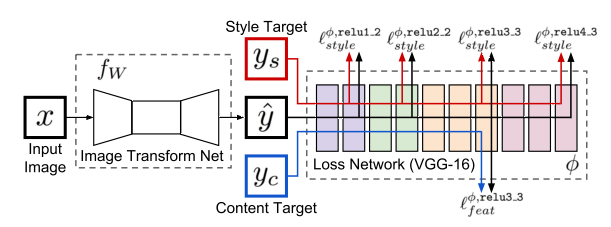

In [7]:
method=Image.open('/home/sravya/Documents/SR/Method/method.png'); method

Key improvement: Instead of starting from noise image, we train the transform network and optimize for its op using same loss functions.

Steps:
    1. Create VGG
    2. Create FW network which takes content image as input and stylized image as output

# Read data

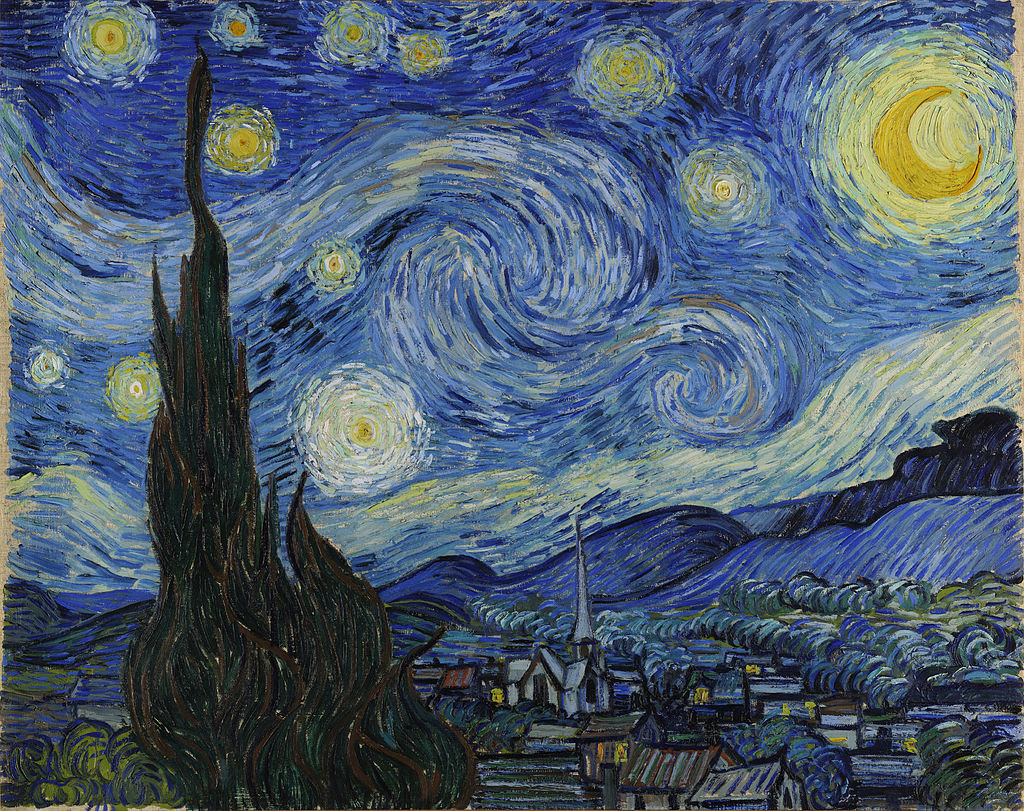

In [8]:
dpath='/home/sravya/data/'
train_ip = bcolz.open(dpath+'trn_resized_288.bc')[:]

style_name='style_transfer/starry_night.jpg'
style_img_path = dpath+ style_name
style_img_raw = Image.open(style_img_path);style_img_raw

In [18]:
inp_shape = train_ip.shape[1:];inp_shape

(288, 288, 3)

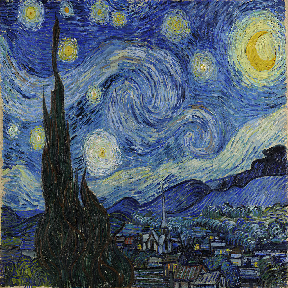

In [19]:
style_img = style_img_raw.resize(inp_shape[:2]);style_img

# Create VGG

In [11]:
vgg_inp=Input(inp_shape)
vgg= VGG16(include_top=False, input_tensor=vgg_inp)
for l in vgg.layers: l.trainable=False

# Image transformation network

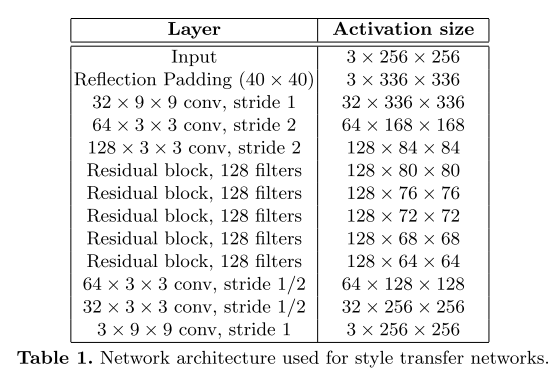

In [12]:
Image.open('/home/sravya/Documents/ST/Realtime_ST.png')

In [13]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [14]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

In [15]:
#These are replaced
def res_block(ip, nf=128):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

In [16]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

In [20]:
inp=Input(inp_shape)
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

# Create Style/Content model from VGG

In [21]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [22]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

In [23]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [ ]:
vgg_content.summary()

In [ ]:
vgg1.summary()

# Combine the networks and attach a final loss lambda layer

In [25]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style_img,0))]

In [26]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 144, 144, 128], dtype=int32),
 array([  1,  72,  72, 256], dtype=int32),
 array([  1,  36,  36, 512], dtype=int32),
 array([  1,  18,  18, 512], dtype=int32)]

In [29]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))
w=[0.1, 0.2, 0.6, 0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [30]:
loss = Lambda(tot_loss)(vgg1+vgg2)
m_style = Model([inp, vgg_inp], loss)
m_style.compile('adam', 'mae')

# Fit the model

In [34]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [35]:
targ = np.zeros((train_ip.shape[0], 1))
m_style.fit([train_ip, train_ip], targ, 8, 2, **parms)

# Split image transformation model and save weights for inference

In [36]:
top_model = Model(inp, outp)

In [37]:
p = top_model.predict(arr_hr[:20])

NameError: name 'arr_hr' is not defined

In [ ]:
plt.imshow(np.round(p[1]).astype('uint8'));

In [ ]:
top_model.save_weights(dpath+'style_final.h5')